# Fig. 1 Introducing the spatial pattern 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from scipy.optimize import minimize, basinhopping
from tqdm import tqdm
from glob import glob
from pathlib import Path
from diptericin_paper_utils import dpt, rc_params, style_axes, colors, fontsize, linewidth, standard_ap, fb_start_id

/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
"""plot style"""
mpl.rcParams.update(rc_params)

In [3]:
"""for inline or pop out plots"""
#%matplotlib qt
%matplotlib inline

In [4]:
"""insert path to the folder of all data files here"""
path_to_supplemental_data_files = r'/home/brandon/Documents/Code/diptericin-paper/SupplementalDataFiles_revision'

# Fig. 1A,B,E, S1A,C
Single-cell measurements of DptA-GFP levels. Run these cells in a row. Fig. 1A uses pilot data that were done at a 10x diluted bacterial concentration.


In [5]:
"""load the data"""
df_eL3_24 = pd.read_csv(path_to_supplemental_data_files + '/Fig1/ecoli_3h-25C_dil10x.csv')
df_mL3_24 = pd.read_csv(path_to_supplemental_data_files + '/Fig1/ecoli_18h-25C_dil10x.csv')
df_emL3_24 = pd.read_csv(path_to_supplemental_data_files + '/Fig1/ecoli_18h-18C_dil10x.csv')
df_mock_1 = pd.read_csv(path_to_supplemental_data_files + '/Fig1/mock_18h-18C.csv')
df_mock_2 = pd.read_csv(path_to_supplemental_data_files + '/Fig1/mock_3h-25C.csv')
df_no_inj_1 = pd.read_csv(path_to_supplemental_data_files + '/Fig1/no_inj_18h-25C.csv')
df_no_inj_2 = pd.read_csv(path_to_supplemental_data_files + '/Fig1/no_inj_18h-18C.csv')

# combine the mocks
tmp_df = df_mock_2.copy()
tmp_df.experiment_id += df_mock_1.experiment_id.max() + 1
df_mock = pd.concat((df_mock_1, tmp_df), axis=0)

# combine the no injections
tmp_df = df_no_inj_2.copy()
tmp_df.experiment_id += df_no_inj_1.experiment_id.max() + 1
df_no_inj = pd.concat((df_no_inj_1, tmp_df), axis=0)


### Fig 1A
errorbar plot of total intensities

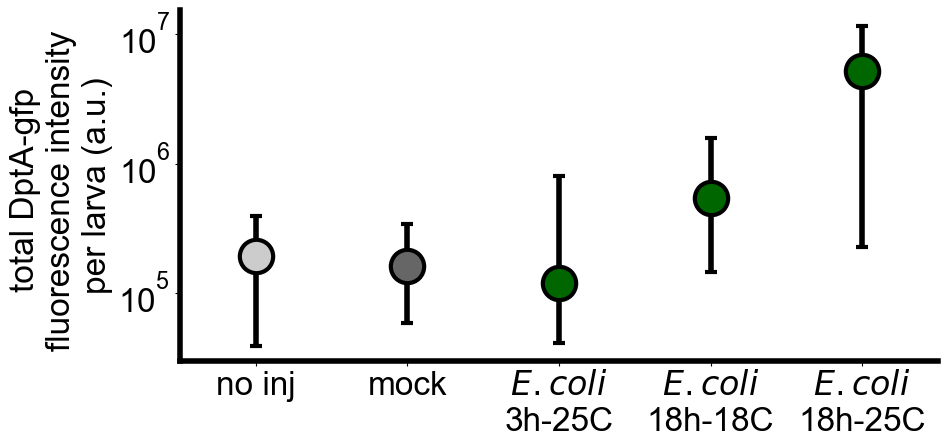

In [6]:
# plot of total intensities
plt.figure(figsize=(10,5))
sigma_x = 0.02
markersize=24
alpha=1

all_dfs = [df_no_inj, df_mock, df_eL3_24, df_emL3_24, df_mL3_24]
color_strs = ['no_inj', 'mock', 'e.coli', 'e.coli', 'e.coli']
for i, df in enumerate(all_dfs):
    intens = df.groupby(by='experiment_id').sum().dpt_gfp.values
    
    l, m, u = np.quantile(intens, [0.25, 0.5, 0.75])
    errors = np.expand_dims(np.array([l, u]), axis=1)
    
    plt.errorbar(i, m, yerr=errors, marker='o', markerfacecolor=colors[color_strs[i]], markersize=markersize, alpha=alpha,
                linewidth=0, elinewidth=4, ecolor='k', capsize=4, capthick=4, markeredgecolor='k', markeredgewidth=3)
    #plt.plot(i * np.ones(len(intens)) + sigma_x * np.random.normal(size=len(intens)), intens, 'ko',
           # markerfacecolor=colors[color_strs[i]], markersize=markersize, alpha=alpha)


plt.xticks([0, 1, 2, 3, 4], labels=['no inj', 'mock', '$E. coli$ \n3h-25C', '$E.coli$ \n18h-18C', '$E.coli$ \n18h-25C'], fontsize=fontsize)
plt.xlim([-0.5, 4.5])
plt.ylabel(f'total {dpt}-gfp \nfluorescence intensity \nper larva (a.u.)', fontsize=fontsize)
plt.yscale('log')
plt.minorticks_off()
ax = style_axes(plt.gca())

In [63]:
#plt.savefig(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/supplemental_figures/total_dpt-gfp_by_treatment.pdf')

### Fig. 1B
scatter plot of median intensities

In [7]:
"""high dose data"""
# 18h-18C 24 hpi E. coli
df_inj = pd.read_csv(path_to_supplemental_data_files + '/Fig1/ecoli_18h-18C.csv')
# 18h-18C 24 hpi mock
df_mock = pd.read_csv(path_to_supplemental_data_files + '/Fig1/mock_18h-18C.csv')
# 18h-18C 24 hpi no injection
df_no = pd.read_csv(path_to_supplemental_data_files + '/Fig1/no_inj_18h-18C.csv')

"""older 10x diluted data"""
# 3h-22C 24 hpi mock
df_e_mock = pd.read_csv(path_to_supplemental_data_files + '/Fig1/mock_18h-18C.csv')
# 18h-24C 24 hpi no injection
df_m_no =pd.read_csv(path_to_supplemental_data_files + '/Fig1/no_inj_18h-18C.csv')



In [8]:
"""threshold for dividing samples based on median intensity"""
partial_thresh = 4000

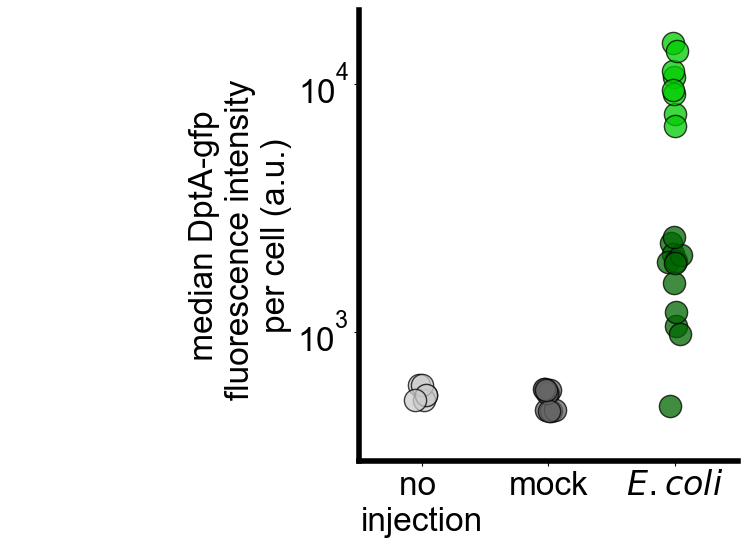

In [9]:
"""scatter plot of median intensities"""
plt.figure(figsize=(8,6))
sigma_x = 0.02

# no injection --- pool all samples
x = 0
color = colors['no_inj']
all_medians = []
df = df_no
medians = df.groupby(by='experiment_id').median().dpt_gfp.values
all_medians.extend(medians)

df = df_m_no
medians = df.groupby(by='experiment_id').median().dpt_gfp.values
all_medians.extend(medians)

plt.plot(x * np.ones(len(all_medians)) + sigma_x * np.random.normal(size=len(all_medians)), 
         all_medians, 'ko', markerfacecolor=color, markersize=16, alpha=0.75)

# mock injection --- pool all samples
x = 1
color = colors['mock']
all_medians = []
df = df_mock
medians = df.groupby(by='experiment_id').median().dpt_gfp.values
all_medians.extend(medians)

df = df_e_mock
medians = df.groupby(by='experiment_id').median().dpt_gfp.values
all_medians.extend(medians)

plt.plot(x * np.ones(len(all_medians)) + sigma_x * np.random.normal(size=len(all_medians)), 
         all_medians, 'ko', markerfacecolor=color, markersize=16, alpha=0.75)

# injected group --- color by partial/complete split
x = 2
all_medians = df_inj.groupby(by='experiment_id').median().dpt_gfp.values
partial_ids = np.where(all_medians < partial_thresh)[0]
complete_ids = np.where(all_medians >= partial_thresh)[0]

# partial
color = colors['e.coli']
sel = partial_ids
plt.plot(x * np.ones(len(all_medians[sel])) + sigma_x * np.random.normal(size=len(all_medians[sel])), 
         all_medians[sel], 'ko', markerfacecolor=color, markersize=16, alpha=0.75)

# complete
color = colors['complete']
sel = complete_ids
plt.plot(x * np.ones(len(all_medians[sel])) + sigma_x * np.random.normal(size=len(all_medians[sel])), 
         all_medians[sel], 'ko', markerfacecolor=color, markersize=16, alpha=0.75)

plt.xticks([0, 1, 2], labels=['no \ninjection', 'mock', '$E. coli$'], fontsize=fontsize)
plt.xlim([-0.5, x + 0.5])
plt.yticks([1e3, 1e4])
plt.ylim([3e2, 2e4])
plt.ylabel(f'\n \n \n \n \n median {dpt}-gfp \nfluorescence intensity \nper cell (a.u.)', fontsize=fontsize)
plt.yscale('log')
ax = plt.gca()
ax = style_axes(ax)


In [15]:
#plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Fig1-SpatialPattern/median_inten_dot_plot.pdf')

In [10]:
"""divide samples based on median intensity"""
partial_ids = np.where(all_medians < partial_thresh)[0]
complete_ids = np.where(all_medians >= partial_thresh)[0]

In [11]:
complete_ids

array([ 4,  7,  9, 10, 12, 14, 15, 17])

In [12]:
partial_ids

array([ 0,  1,  2,  3,  5,  6,  8, 11, 13, 16, 18, 19])

### Fig S1A
median dot plot annotated by various metadata

In [13]:
meta = pd.read_csv(path_to_supplemental_data_files + '/Fig1/experiment_metadata.csv')
um_per_px = 0.325

In [14]:
meta

,experiment_id,larva,experiment_date,sex,length (px)
0,0,/media/brandon/Data2/Brandon/fly_immune/Lights...,2023-05-03,F,10329
1,1,/media/brandon/Data2/Brandon/fly_immune/Lights...,2023-05-03,M,10811
2,2,/media/brandon/Data2/Brandon/fly_immune/Lights...,2023-05-03,F,9494
3,3,/media/brandon/Data2/Brandon/fly_immune/Lights...,2023-05-03,F,10117
4,4,/media/brandon/Data2/Brandon/fly_immune/Lights...,2023-05-03,F,10393
5,5,/media/brandon/Data2/Brandon/fly_immune/Lights...,2023-05-03,M,10446
6,6,/media/brandon/Data2/Brandon/fly_immune/Lights...,2023-06-01,M,8669
7,7,/media/brandon/Data2/Brandon/fly_immune/Lights...,2023-06-01,F,11734
8,8,/media/brandon/Data2/Brandon/fly_immune/Lights...,2023-06-01,M,8462
9,9,/media/brandon/Data2/Brandon/fly_immune/Lights...,2023-06-01,F,10549


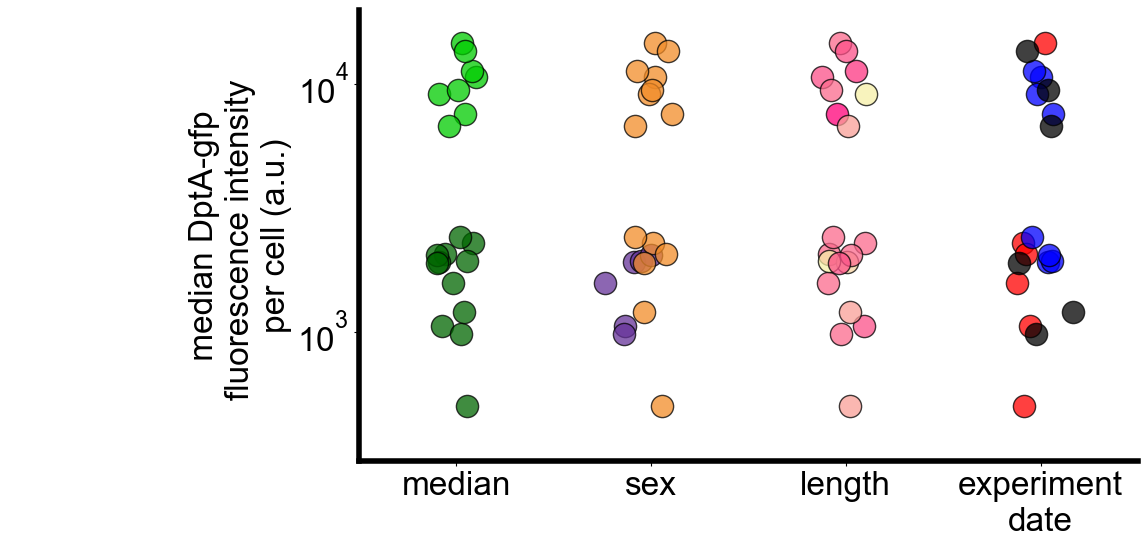

In [15]:
"""scatter plot of median intensities"""
plt.figure(figsize=(12,6))
sigma_x = 0.08

"""color by split"""
# injected group --- color by partial/complete split
x = 0
all_medians = df_inj.groupby(by='experiment_id').median().dpt_gfp.values
partial_ids = np.where(all_medians < partial_thresh)[0]
complete_ids = np.where(all_medians >= partial_thresh)[0]

# partial
color = colors['e.coli']
sel = partial_ids
plt.plot(x * np.ones(len(all_medians[sel])) + sigma_x * np.random.normal(size=len(all_medians[sel])), 
         all_medians[sel], 'ko', markerfacecolor=color, markersize=16, alpha=0.75)

# complete
color = colors['complete']
sel = complete_ids
plt.plot(x * np.ones(len(all_medians[sel])) + sigma_x * np.random.normal(size=len(all_medians[sel])), 
         all_medians[sel], 'ko', markerfacecolor=color, markersize=16, alpha=0.75)


"""color by sex"""
x = 1
# male
color = np.array([102, 51, 153]) / 255
sel = meta.sex == 'M'
plt.plot(x * np.ones(len(all_medians[sel])) + sigma_x * np.random.normal(size=len(all_medians[sel])), 
         all_medians[sel], 'ko', markerfacecolor=color, markersize=16, alpha=0.75)

# female
color = np.array([242, 140, 40]) / 255
sel = meta.sex == 'F'
plt.plot(x * np.ones(len(all_medians[sel])) + sigma_x * np.random.normal(size=len(all_medians[sel])), 
         all_medians[sel], 'ko', markerfacecolor=color, markersize=16, alpha=0.75)


"""color by length"""
x = 2
lengths = meta.get('length (px)').values * um_per_px
length_bins = np.linspace(np.min(lengths), np.max(lengths), 10)
length_bin_ids = np.zeros_like(lengths)
end_color = np.array([255, 0, 120]) / 255
start_color = np.array([246, 239, 167]) / 255
reds = np.linspace(start_color[0], end_color[0], len(length_bins))
greens = np.linspace(start_color[1], end_color[1], len(length_bins))
blues = np.linspace(start_color[2], end_color[2], len(length_bins))

for i in range(len(lengths)):
    length_bin_id = np.where(np.abs(lengths[i] - length_bins) == np.min(np.abs(lengths[i] - length_bins)))[0][0]
    color = [reds[length_bin_id], greens[length_bin_id], blues[length_bin_id]]
    plt.plot(x + sigma_x * np.random.normal(), 
             all_medians[i], 'ko', markerfacecolor=color, markersize=16, alpha=0.75)
    
    
"""color by experiment date"""
x = 3
dates = meta.experiment_date.unique()
plot_colors = ['r', 'b', 'k']
for i, d in enumerate(dates):
    sel = meta.experiment_date == d
    plt.plot(x * np.ones(len(all_medians[sel])) + sigma_x * np.random.normal(size=len(all_medians[sel])), 
         all_medians[sel], 'ko', markerfacecolor=plot_colors[i], markersize=16, alpha=0.75)


plt.xticks([0, 1, 2, 3], labels=['median', 'sex', 'length', 'experiment\ndate'], fontsize=fontsize)
plt.xlim([-0.5, x + 0.5])
plt.yticks([1e3, 1e4])
plt.ylim([3e2, 2e4])
plt.ylabel(f'\n \n \n \n \n median {dpt}-gfp \nfluorescence intensity \nper cell (a.u.)', fontsize=fontsize)
plt.yscale('log')
ax = plt.gca()
ax = style_axes(ax)


In [60]:
#plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Fig1-SpatialPattern/median_inten_dot_plot_meta_labels.pdf')

### Fig. 1E
Single-cell DptA fluorescence intensity distributions

In [16]:
n_bins = 20 + 1


In [17]:
# assemble mock injection distribution
all_mock_intens = []
df = df_mock
intens = df.dpt_gfp.values
all_mock_intens.extend(intens)

df = df_e_mock
intens = df.dpt_gfp.values
all_mock_intens.extend(intens)

mock_bins = np.logspace(np.min(np.log10(all_mock_intens)), np.max(np.log10(all_mock_intens)), n_bins)
counts, _ = np.histogram(all_mock_intens, mock_bins)

mock_prob_dens = counts / np.sum(counts) / np.diff(mock_bins)
mock_bins = mock_bins[:-1]


In [18]:
"""combine both mock dataframes into one"""
tmp_df = df_e_mock.copy()
tmp_df.experiment_id += df_mock.experiment_id.max() + 1
df_all_mock = pd.concat((df_mock, tmp_df), axis=0)

In [19]:
df_partial = df_inj[[eid in partial_ids for eid in df_inj.experiment_id]]
df_complete = df_inj[[eid in complete_ids for eid in df_inj.experiment_id]]


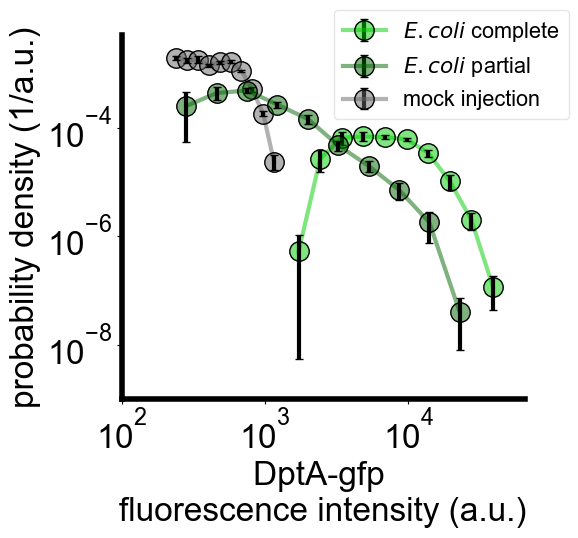

In [20]:
"""plot mock, partial, and complete dists on one graph"""
n_bootstraps = 100
plt.figure(figsize=(6, 6))

"""complete"""
df = df_complete
n_bins = 10 + 1

# construct array of individual prob dens for error bars
intens = df.dpt_gfp.astype('float32').values
bins = np.floor(np.logspace(np.min(np.log10(intens)), np.max(np.log10(intens)), n_bins))

eids = df.experiment_id.unique()
prob_dens_bootstrap = np.zeros((n_bootstraps, len(bins) -1))
for n in range(n_bootstraps):
    these_ids = np.random.choice(eids, size=len(eids))
    these_intens = []
    for j in range(len(these_ids)):
        these_intens.extend(df[df.experiment_id == these_ids[j]].dpt_gfp.values.astype('float'))
    these_intens = np.array(sorted(these_intens))
    counts, _ = np.histogram(these_intens, bins)
    prob_dens = counts / np.sum(counts) / np.diff(bins)
    prob_dens_bootstrap[n] = prob_dens
    
sigma_prob_dens = np.nanstd(prob_dens_bootstrap, axis=0)

# now plot a pooled distribution
intens = df.dpt_gfp.astype('float32').values
counts, _ = np.histogram(intens, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
bins = bins[:-1]

plt.errorbar(bins, prob_dens, sigma_prob_dens, ecolor='k', elinewidth=3, capsize=3, marker='o', 
             markersize=14, color=colors['complete'] + [0.5], linewidth=3, markeredgecolor='k', markerfacecolor=colors['complete'] + [0.5], 
             barsabove=True, label='$E.coli$ complete')


"""partial"""
df = df_partial
n_bins = 10 + 1

# construct array of individual prob dens for error bars
intens = df.dpt_gfp.astype('float32').values
bins = np.logspace(np.min(np.log10(intens)), np.max(np.log10(intens)), n_bins)

eids = df.experiment_id.unique()
prob_dens_bootstrap = np.zeros((n_bootstraps, len(bins) -1))
for n in range(n_bootstraps):
    these_ids = np.random.choice(eids, size=len(eids))
    these_intens = []
    for j in range(len(these_ids)):
        these_intens.extend(df[df.experiment_id == these_ids[j]].dpt_gfp.values.astype('float'))
    these_intens = np.array(sorted(these_intens))
    counts, _ = np.histogram(these_intens, bins)
    prob_dens = counts / np.sum(counts) / np.diff(bins)
    prob_dens_bootstrap[n] = prob_dens
    
sigma_prob_dens = np.nanstd(prob_dens_bootstrap, axis=0)

# now plot a pooled distribution
intens = df.dpt_gfp.astype('float32').values
counts, _ = np.histogram(intens, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
bins = bins[:-1]

plt.errorbar(bins, prob_dens, sigma_prob_dens, ecolor='k', elinewidth=3, capsize=3, marker='o', 
             markersize=14, color=colors['e.coli'] + [0.5], linewidth=3, markeredgecolor='k', markerfacecolor=colors['e.coli'] + [0.5], 
             barsabove=True, label='$E.coli$ partial', zorder=10)


"""mock"""
df = df_all_mock
n_bins = 10 + 1

# construct array of individual prob dens for error bars
intens = df.dpt_gfp.astype('float32').values
bins = np.logspace(np.min(np.log10(intens)), np.max(np.log10(intens)), n_bins)

eids = df.experiment_id.unique()
prob_dens_bootstrap = np.zeros((n_bootstraps, len(bins) -1))
for n in range(n_bootstraps):
    these_ids = np.random.choice(eids, size=len(eids))
    these_intens = []
    for j in range(len(these_ids)):
        these_intens.extend(df[df.experiment_id == these_ids[j]].dpt_gfp.values.astype('float'))
    these_intens = np.array(sorted(these_intens))
    counts, _ = np.histogram(these_intens, bins)
    prob_dens = counts / np.sum(counts) / np.diff(bins)
    prob_dens_bootstrap[n] = prob_dens
    
sigma_prob_dens = np.nanstd(prob_dens_bootstrap, axis=0)

# now plot a pooled distribution
intens = df.dpt_gfp.astype('float32').values
counts, _ = np.histogram(intens, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
bins = bins[:-1]

plt.errorbar(bins, prob_dens, sigma_prob_dens, ecolor='k', elinewidth=3, capsize=3, marker='o', 
             markersize=14, color=colors['mock'] + [0.5], linewidth=3, markeredgecolor='k', markerfacecolor=colors['mock'] + [0.5], 
             barsabove=True, label='mock injection', zorder=0)




plt.xscale('log')
plt.yscale('log')
plt.xlabel(f'{dpt}-gfp \nfluorescence intensity (a.u.)', fontsize=fontsize)
plt.ylabel('probability density (1/a.u.)', fontsize=fontsize)
plt.legend(fontsize=0.65 * fontsize, loc='upper left', bbox_to_anchor=(0.5, 1.1), ncol=1, fancybox=True, framealpha=0.5)

plt.xlim([100, 65000])
plt.ylim([1e-9, 5e-3])
plt.yticks([1e-8, 1e-6, 1e-4])
ax = plt.gca()
ax = style_axes(ax)

In [150]:
#plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Fig1-SpatialPattern/mock_partial_complete_dists_errorbars.pdf')

## Fig. S1C
Individual single-cell DptA probability distributions

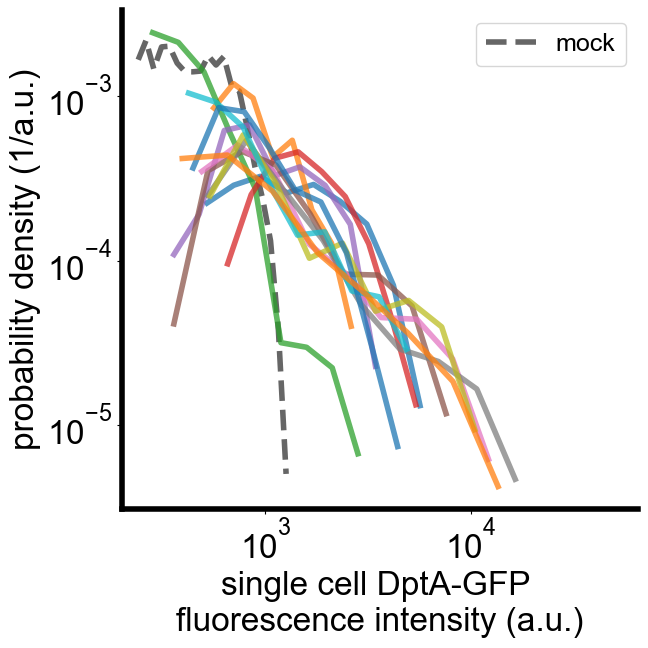

In [21]:
"""plot examples of individual partial dists"""
df_partial = df_inj[[eid in partial_ids for eid in df_inj.experiment_id]]
df_complete = df_inj[[eid in complete_ids for eid in df_inj.experiment_id]]
n_bins = 20 + 1
plt.figure(figsize=(7, 7))

"""partial"""
# plot mock first
plt.plot(mock_bins, mock_prob_dens, '--', linewidth=linewidth, color=colors['mock'], label='mock')

# plot individual partial dists
df = df_partial
good_eids = partial_ids
for i, eid in enumerate(good_eids):
    sub_df = df[df.experiment_id == eid]
    intens = sub_df.dpt_gfp.astype('float32').values
    bins = np.logspace(np.min(np.log10(intens)), np.max(np.log10(intens)), int(n_bins / 2))
    counts, _ = np.histogram(intens, bins)
    prob_dens = counts / np.sum(counts) / np.diff(bins)
    bins = bins[:-1]
    bins = bins[prob_dens > 1e-7]
    prob_dens = prob_dens[prob_dens > 1e-7]
    plt.plot(bins, prob_dens, '-', linewidth=linewidth, alpha=0.75, label='_nolabel_')



plt.xscale('log')
plt.yscale('log')
plt.xlabel(f'single cell {dpt}-GFP \nfluorescence intensity (a.u.)', fontsize=fontsize)
plt.ylabel('probability density (1/a.u.)', fontsize=fontsize)
plt.legend(fontsize=0.75 * fontsize)
plt.xlim([200, 65000])
ax = plt.gca()
ax = style_axes(ax)




In [29]:
#plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Fig1-SpatialPattern/individual_partial_dists.pdf')

# Fig1D, FigS1B
1D DptA distributions along the anterior-posterior axis

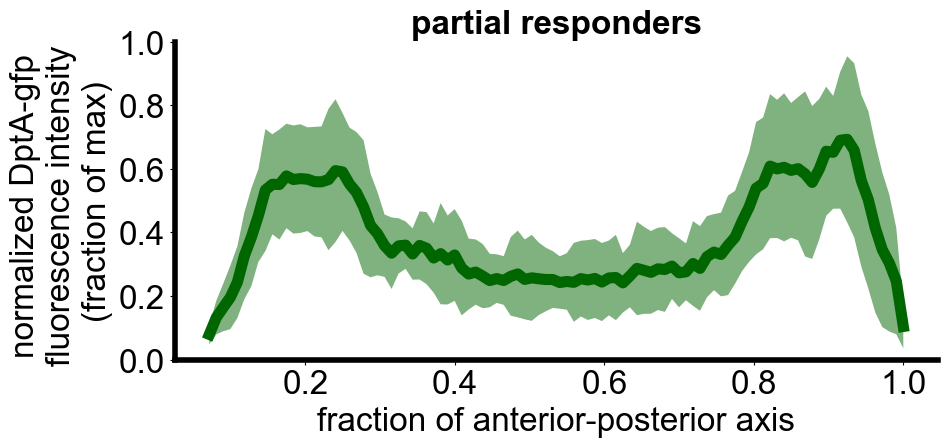

In [23]:
"""partial normalized"""
with open(path_to_supplemental_data_files + r'/Fig1/DptA_line_dist_arr_partial.pkl', 'rb') as f:
    line_dist_arr = pickle.load(f)
plt.figure(figsize=(10,5))
x = np.linspace(standard_ap[fb_start_id], 1, line_dist_arr.shape[1])

"""plot individual dists"""
norm_line_dist_arr = np.zeros_like(line_dist_arr)
for i in range(len(line_dist_arr)):
    norm_line_dist_arr[i] = line_dist_arr[i] / np.max(line_dist_arr[i])

m = np.mean(norm_line_dist_arr, axis=0)
s = np.std(norm_line_dist_arr, axis=0) 
l = m - s
u = m + s
plt.fill_between(x, l, u, facecolor=colors['e.coli'], alpha=0.5)
plt.plot(x, m, '-', linewidth=2*linewidth, color=colors['e.coli'], label='mean')
plt.xlabel('fraction of anterior-posterior axis', fontsize=fontsize)
plt.ylabel(f'normalized {dpt}-gfp \nfluorescence intensity \n(fraction of max)', fontsize=fontsize)
plt.title('partial responders', fontsize=fontsize, fontweight='bold')
plt.ylim([0, 1])
ax = style_axes(plt.gca())



In [25]:
#plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Fig1-SpatialPattern/partial_normalized_ap_dist_v2.pdf')

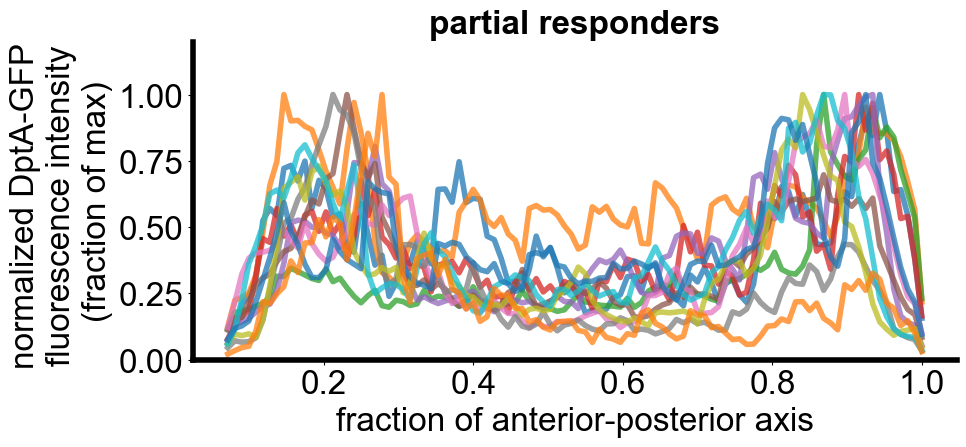

In [24]:
"""individual partial normalized"""
plt.figure(figsize=(10,5))
x = np.linspace(standard_ap[fb_start_id], 1, line_dist_arr.shape[1])
"""plot individual dists first"""
for i in range(len(line_dist_arr)):
    if i == 0:
        label = 'individual larvae'
    else:
        label = '_nolabel_'
    plt.plot(x, line_dist_arr[i] / np.max(line_dist_arr[i]), '-', linewidth=linewidth, alpha=0.75, label=label)

plt.xlabel('fraction of anterior-posterior axis', fontsize=fontsize)
plt.ylabel(f'normalized {dpt}-GFP \nfluorescence intensity \n(fraction of max)', fontsize=fontsize)
plt.title('partial responders', fontsize=fontsize, fontweight='bold')
plt.ylim([0, 1.2])
ax = style_axes(plt.gca())



In [29]:
#plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Fig1-SpatialPattern/partial_normalized_individual_ap_dists.pdf')